# Vorbereitung

#### Importe

In [1]:
import requests

from utilities import print_dataset_graph, get_df_for_country

## URLs

URLs die für die Nutzung des Frameworks zur verfügung stehen

<ul>
    <li><b>https://apps.exxcellent.de/prognoseframework/api/v1/info/<i>&laquo;type&raquo; </i></b>: Bietet generelle Informationen </li>
        <ul>
        <li><b>models </b>: Gibt eine Liste aller univariaten Modelle zurück</li>
        <li><b>multivariate_models </b>: Gibt eine Liste aller mulitvariaten Modelle zurück</li>
        </ul>
    <li><b>https://apps.exxcellent.de/prognoseframework/api/v1/files </b>: Bietet Möglichkeiten, Dateien hoch- oder herunterzuladen</li>
    <li><b>https://apps.exxcellent.de/prognoseframework/api/v1/data </b>: Schnittstelle zum Bearbeiten und Analysieren von Datensätzen</li>
    <ul>
        <li> + <b>/<i>&laquo;file id&raquo; </i></b>: mit bereits hochgeladener Datei</li>
    </ul>
    <li><b>https://apps.exxcellent.de/prognoseframework/api/v1/models </b>: Training, und verwaltung trainierter Modelle</li>
    <ul>
        <li> + <b>/<i>&laquo;model id&raquo;</i>/prediction </b>: Erstellt Vorhersagen mit einem bestehenden Modell</li>
    </ul>
    <li><b>https://apps.exxcellent.de/prognoseframework/api/v1/auto </b>: Trainiert mehrere Modelle und wählt das beste aus</li>
    <ul>
        <li> + <b>/<i>&laquo;file id&raquo; </i></b>: mit bereits hochgeladener Datei</li>
    </ul>
</ul>

# Vorgehensweise des Frameworks

![Übersicht](img/uebersicht.png)

## Verfügbare Modelle prüfen

Frägt beim Framework nach, welche Modelle verfügbar sind

In [2]:
response_uni = requests.get("https://apps.exxcellent.de/prognoseframework/api/v1/info/models")
response_multi = requests.get("https://apps.exxcellent.de/prognoseframework/api/v1/info/multivariate_models")

print(f'Univariate models: {response_uni.json()["models"]}')
print(f'Multivariate models: {response_multi.json()["models"]}')


Univariate models: ['AR', 'ES']
Multivariate models: []


# Daten Analysieren und Bearbeiten

## Datei hochladen

Dateien können auf das Framework hochgeladen werden, um sie später zu analysieren oder zum trainieren von Vorhersagemodellen zu nutzen.

![Datei Hochladen](img/uebersicht_hochladen.png)

{'file_id': 40}


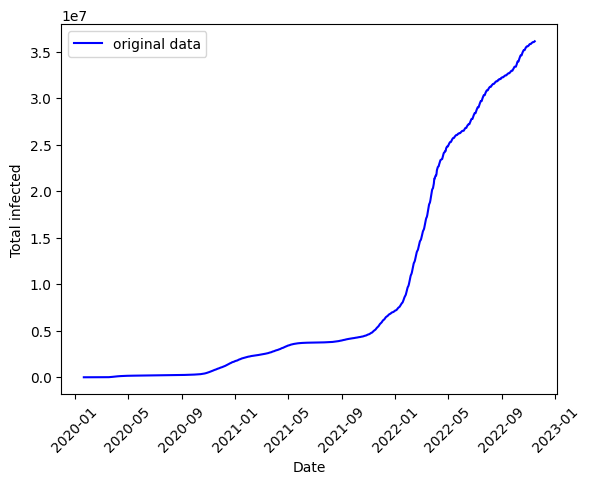

In [3]:
file_path = get_df_for_country('Germany')

form_data = {
    "separator" : ";"
}

with open(file_path, 'rb') as file:
    files = {"data": (file_path, file)}
    print_dataset_graph(file_path)
    response_upload = requests.put("https://apps.exxcellent.de/prognoseframework/api/v1/files", params=form_data, files=files)

print(response_upload.json())
file_id = response_upload.json()['file_id']

#### Daten bearbeiten

![Daten bearbeiten](img/uebersicht_bearbeiten.png)

Daten können for der Nutzung bearbeitet werden. Die verfügbaren Bearbeitungsoptionen sind:
<ul>
    <li> Fehlende Einträge finden und hinzufügen </li>
    <li> Fehlende Werte interpolieren </li>
    <li> Die Auflösung des Datensatzes zu ändern. Die möglichen Auflösungen sind: </li>
    <ul>
        <li>S : Sekunden</li>
        <li>min : Minuten</li>
        <li>H : Stunden</li>
        <li>D : Tage</li>
        <li>W : Wochen</li>
        <li>M : Monate</li>
        <li>Q : Vierteljährlich</li>
        <li>Y : Jahre</li>
    </ul>
</ul>

![Daten Bearbeitung](img/data_preparation.png)

In [4]:
response_prepare = requests.post(f"https://apps.exxcellent.de/prognoseframework/api/v1/data/prepare/{file_id}", params={"interval" : 'D'})
print(response_prepare.json())

{'file_id': 40, 'seasonality': [365.25, 7.0], 'trend_component': [], 'seasonal_component': [], 'random error': []}


## Daten Analysieren

![Daten Analysieren](img/uebersicht_analysieren.png)

Die hochgeladenen Daten können analysiert werden, um informationen, wie fehlende Einträge oder enthaltenen Saisonalität zu erhalten.

In [5]:
response_missing = requests.post(f"https://apps.exxcellent.de/prognoseframework/api/v1/data/missing_entries/{file_id}")
print("Missing entries: ", response_missing.json()['missing_entries'])

response_seasonality = requests.post(f"https://apps.exxcellent.de/prognoseframework/api/v1/data/seasonality/{file_id}")
print("Seasonal periods: ", response_seasonality.json()['seasonality'])

Missing entries:  []
Seasonal periods:  [343.0, 147.0, 114.33333333333333, 79.15384615384616, 64.3125, 51.45, 41.16, 6.952702702702703]


In [6]:
# allowed intervals: S, min, H, D, W, M, Q or A
response_seasonality = requests.post(f"https://apps.exxcellent.de/prognoseframework/api/v1/data/seasonality/{file_id}", params={"interval" : 'D'})
print("Seasonal periods: ", response_seasonality.json()['seasonality'])

Seasonal periods:  [365.25, 7.0]


# Zeitreihenvorhersage

## Modelle trainieren

![Modell trainieren](img/uebersicht_trainieren.png)

Um Zeitreihenvorhersagen zu erstellen, können verschiedene Modellarten trainiert werden:
<ul>
    <li>Autoregression (AR)</li>
    <li>Exponential Smoothing (ES)</li>
</ul>

Die Parameter der Modelle werden, sofern vorhanden, im Standard optimiert.

In [7]:
response_training = requests.post("https://apps.exxcellent.de/prognoseframework/api/v1/models", params={"data_id" : file_id, "model_type" : 'ES'})

print(response_training)
print("Model id: ", response_training.json()['model_id'])

print("Errors: ", response_training.json()['errors'])
print("Training duration: ", response_training.json()['duration'])
print("Model parameters", response_training.json()['parameters'])


<Response [200]>
Model id:  81
Errors:  {'aic': 17000.9304347028, 'bic': 17019.782259505508, 'rmse': 6467733.14001301}
Training duration:  0.2114427089691162
Model parameters {'trend': 'add', 'seasonal': None, 'seasonality': 6.952702702702703}


## Automatische Modellauswahl

Um dem Entwickler die Arbeit zu erleichtern und nicht unterschiedliche Modelle testen zu müssen, trainiert und evaluiert das Framework die Modelle und wählt anhand einer Metric ein für den Datensatz passendes Modell aus.

In [8]:
response_auto_selection = requests.post(f"https://apps.exxcellent.de/prognoseframework/api/v1/auto/{file_id}",
                                        params={"interval" : "D",
                                                "models" : 'AR,ES'})

model_id = response_auto_selection.json()['final_model']['model_id']

print(response_auto_selection.json()['final_model']['model_type'])

print(response_auto_selection.json())

ES
{'final_model': {'model_type': 'ES', 'model_id': 84, 'errors': {'aic': 20939.578081240565, 'bic': 20993.87785133474, 'rmse': -1}, 'duration': 0.2218019962310791, 'parameters': {'trend': 'add', 'seasonal': 'add', 'seasonality': 7.0}}, 'training_results': [{'model_name': 'AR', 'errors': {'aic': 18130.65849749643, 'bic': 18238.633424842417, 'rmse': 56871442.55609285}, 'duration': 1.5081849098205566, 'parameters': {'lags': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}}, {'model_name': 'ES', 'errors': {'aic': 16466.59423351912, 'bic': 16518.436751726567, 'rmse': 7635137.154300633}, 'duration': 0.30158472061157227, 'parameters': {'trend': 'add', 'seasonal': 'add', 'seasonality': 7.0}}]}


## Vorhersagen

![Vorhersage erstellen](img/uebersicht_vorhersage.png)

Die trainierten Modelle können anschließend für Vorhersagen genutzt werden.

[36153945.508509144, 36208049.37191182, 36259995.99036266, 36274087.955673076, 36274444.21709894, 36318418.58331554, 36337027.792025484, 36387312.04002396, 36441415.903426625, 36493362.52187747, 36507454.487187885, 36507810.748613745, 36551785.114830345, 36570394.32354029, 36620678.57153877, 36674782.43494143, 36726729.053392276, 36740821.0187027, 36741177.28012855, 36785151.64634515]


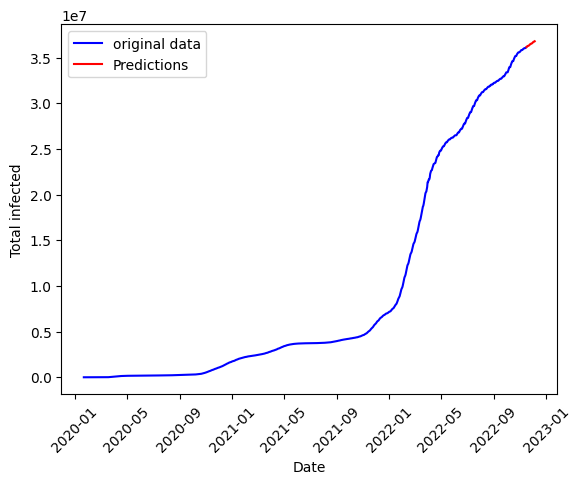

In [9]:
response_prediction = requests.post(f"https://apps.exxcellent.de/prognoseframework/api/v1/models/{model_id}/prediction",
                                     params={"prediction_interval": 20})

prediction = response_prediction.json()['prediction']

print(prediction)

print_dataset_graph(file_path, prediction)


# Aufgabe

<ul>
<li>Erstellen sie mithilfe der Methode 'get_df_for_country' einen Datensatz für das Land Österreich (Austria)</li>
<li>Laden Sie diesen Datensatz auf das Framework hoch</li>
<li>Nutzen Sie die automatische Modellauswahl um mit diesem Datensatz ein Modell zu trainieren. Eine Vorbearbeitung der Daten ist nicht nötig, da dies vom Framework bereits gemacht wird.</li>
<li>Führen Sie für das ausgewählte Modell ('final_model') eine Vorhersage für 50 Einträge aus. (Kann auch mit der vorherigen Aufgabe kombiniert werden)</li>
<li>Zeichnen Sie mit der Methode 'print_dataset_graph' den Verlauf der Daten und der Vorhersage.</li>
</ul>

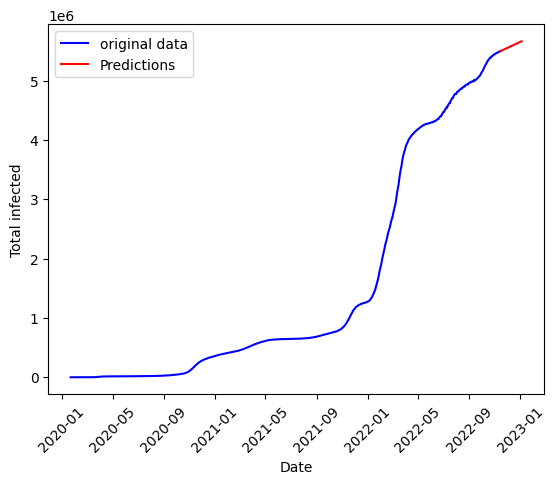

In [10]:
austria_path = get_df_for_country('Austria')

form_data = {
    "separator": ";"
}

with open(austria_path, 'rb') as file:
    files = {"data": (austria_path, file)}
    response_upload = requests.put("https://apps.exxcellent.de/prognoseframework/api/v1/files", params=form_data, files=files)

austria_file_id = response_upload.json()['file_id']

austria_auto = requests.post(f"https://apps.exxcellent.de/prognoseframework/api/v1/auto/{austria_file_id}",
                             params={"interval" : "D", "prediction_interval": 50})

print_dataset_graph(austria_path, austria_auto.json()['prediction'])

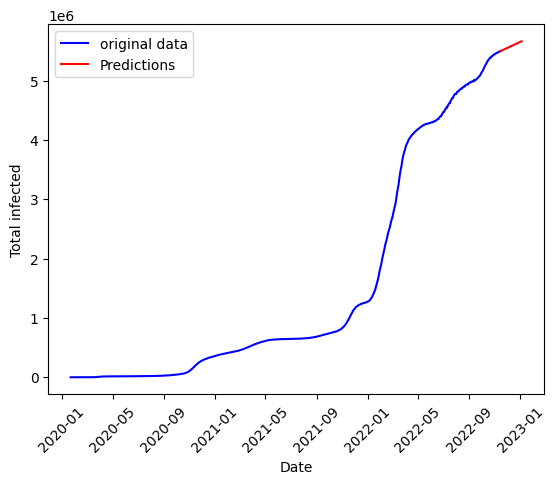

In [12]:
austria_path = get_df_for_country("Austria")
with open(austria_path, 'rb') as file:
    print_dataset_graph(austria_path, requests.post("https://apps.exxcellent.de/prognoseframework/api/v1/auto", params={"interval": "D", "prediction_interval" : 50}, files={"data": (austria_path, file)}).json()['prediction'])